#Install Libraries and Packages

In [ ]:
!pip install tensorflow keras matplotlib opencv-python numpy

# Imports

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import  Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cifar10

In [ ]:
# Load into train and test sets
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 8s 0us/step


In [ ]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.0
X_test /= 255.0

In [ ]:
#Split into train and val sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [ ]:
#Encoding
encoder = OneHotEncoder()

encoder.fit(Y_train)

Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [ ]:
print(Y_train.shape)
print(X_train.shape)

print(Y_val.shape)
print(X_val.shape)

print(Y_test.shape)
print(X_test.shape)

(40000, 10)
(40000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)


In [ ]:
#Data augmentation
aug = ImageDataGenerator(
                            horizontal_flip=True,
                            width_shift_range=0.05,
                            height_shift_range=0.05
                            )
aug.fit(X_train)

In [ ]:
print(Y_train.shape)
print(X_train.shape)

print(Y_val.shape)
print(X_val.shape)

print(Y_test.shape)
print(X_test.shape)

(40000, 10)
(40000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)


## MODEL3 (ResNet18)

1. Developing the ResNet50 model

In [ ]:
class Block(Model):
    def __init__(self, channels: int, down_sample=False):
        super().__init__()
        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]
        kernel = (3, 3)
        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0], kernel_size=kernel, padding="same", kernel_initializer="he_normal")
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1], kernel_size=kernel, padding="same", kernel_initializer="he_normal")
        self.bn_2 = BatchNormalization()
        self.merge = Add()
        if self.__down_sample:
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), padding="same", kernel_initializer="he_normal")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [ ]:
class Resnet18(Model):
    def __init__(self, no_classes, **kwargs):
        super().__init__(**kwargs)

        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = Block(64)
        self.res_1_2 = Block(64)
        self.res_2_1 = Block(128, down_sample=True)
        self.res_2_2 = Block(128)
        self.res_3_1 = Block(256, down_sample=True)
        self.res_3_2 = Block(256)
        self.res_4_1 = Block(512, down_sample=True)
        self.res_4_2 = Block(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(no_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
model = Resnet18(10)
model.build(input_shape = (None,32,32,3))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2. Compiling the model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "resnet18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 block (Block)               multiple                  74368     
                                                                 
 block_1 (Block)             multiple                  74368     
                                                                 
 block_2 (Block)             multiple                  231

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuracy")
STEPS = len(X_train) / 256

3. Calling fit function for MODEL3

In [ ]:
history=model.fit(
    aug.flow(X_train,Y_train,batch_size = 256),
    steps_per_epoch=STEPS,
    validation_data=(X_val, Y_val),
    batch_size=256,
    verbose=1,
    epochs=10,
    callbacks=[es]
)

Epoch 1/10
157/156 [==============================] - ETA: 0s - loss: 1.6269 - accuracy: 0.4325

156/156 [==============================] - 42s 132ms/step - loss: 1.6269 - accuracy: 0.4325 - val_loss: 1.7968 - val_accuracy: 0.3754
Epoch 2/10
157/156 [==============================] - ETA: 0s - loss: 1.2383 - accuracy: 0.5548

156/156 [==============================] - 20s 129ms/step - loss: 1.2383 - accuracy: 0.5548 - val_loss: 1.6346 - val_accuracy: 0.4358
Epoch 3/10
157/156 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.6138

156/156 [==============================] - 20s 130ms/step - loss: 1.0827 - accuracy: 0.6138 - val_loss: 1.3282 - val_accuracy: 0.5335
Epoch 4/10
157/156 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.6587

156/156 [==============================] - 21s 132ms/step - loss: 0.9677 - accuracy: 0.6587 - val_loss: 1.1389 - val_accuracy: 0.6068
Epoch 5/10
157/156 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.6862

156/156 [==============================] - 20s 131ms/step - loss: 0.8878 - accuracy: 0.6862 - val_loss: 1.0788 - val_accuracy: 0.6257
Epoch 6/10
157/156 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7136

156/156 [==============================] - 20s 130ms/step - loss: 0.8142 - accuracy: 0.7136 - val_loss: 1.2733 - val_accuracy: 0.5891
Epoch 7/10
157/156 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.7315

156/156 [==============================] - 21s 132ms/step - loss: 0.7537 - accuracy: 0.7315 - val_loss: 1.0134 - val_accuracy: 0.6661
Epoch 8/10
157/156 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.7542

156/156 [==============================] - 20s 131ms/step - loss: 0.6974 - accuracy: 0.7542 - val_loss: 0.9550 - val_accuracy: 0.6815
Epoch 9/10
157/156 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7649

156/156 [==============================] - 21s 133ms/step - loss: 0.6652 - accuracy: 0.7649 - val_loss: 0.9919 - val_accuracy: 0.6710
Epoch 10/10
157/156 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.7822

156/156 [==============================] - 20s 129ms/step - loss: 0.6164 - accuracy: 0.7822 - val_loss: 0.8713 - val_accuracy: 0.7092


4. Saving the model

In [ ]:
model.save('path/to/model/folder')

In [ ]:
# model = Resnet18(
#                          input_shape=(224,224,3),
#                           weights='imagenet',
#                           include_top=False)

# #Freeze the first 10 layers
# for layer in base_model.layers[:10]:
#       layer.trainable =False
# x=base_model.output
# #x=Conv2D(128,3,3),activation='relu')(x)
# #on the top of the model we add  the layers below:
# x = GlobalAveragePooling2D()(x)
# x = Dense(512,activation='relu')(x)
# x=Dropout(0.3)(x)
# predictions=Dense(10,activation='sigmoid')(x)  # 8 neurons - because we have 8 classes

# model3=Model(inputs=base_model.inputs, outputs=predictions)

# Performance

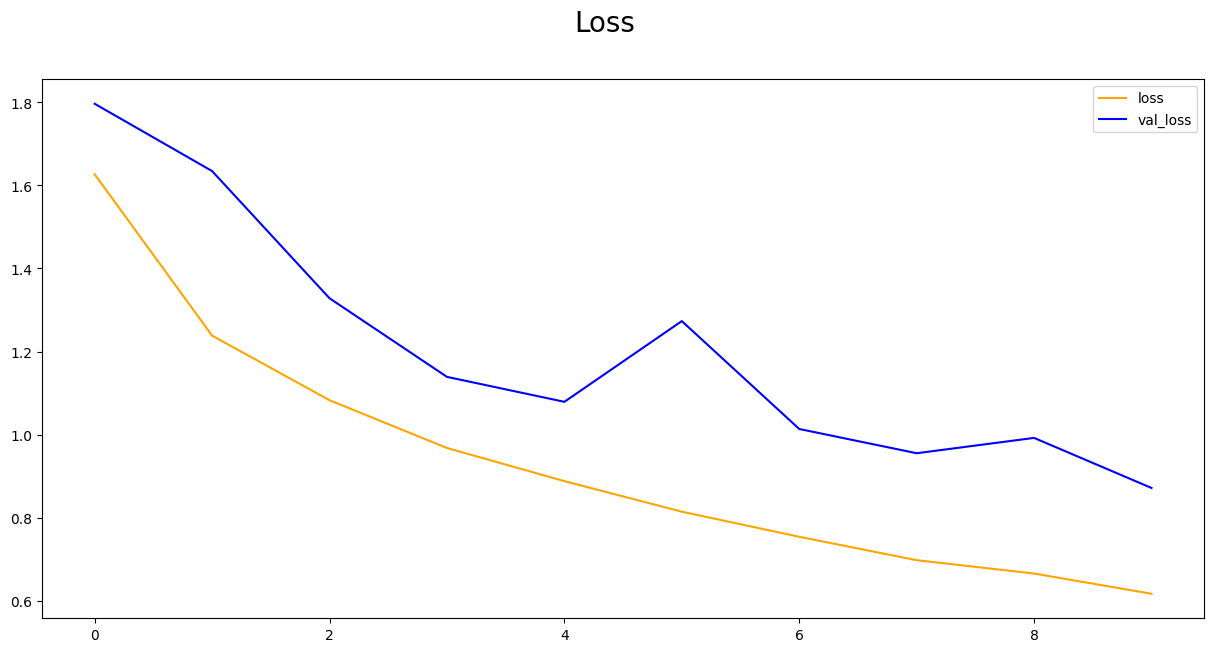

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], color = 'orange', label = 'loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
fig.suptitle ('Loss', fontsize = 20)
plt.legend()
plt.show()

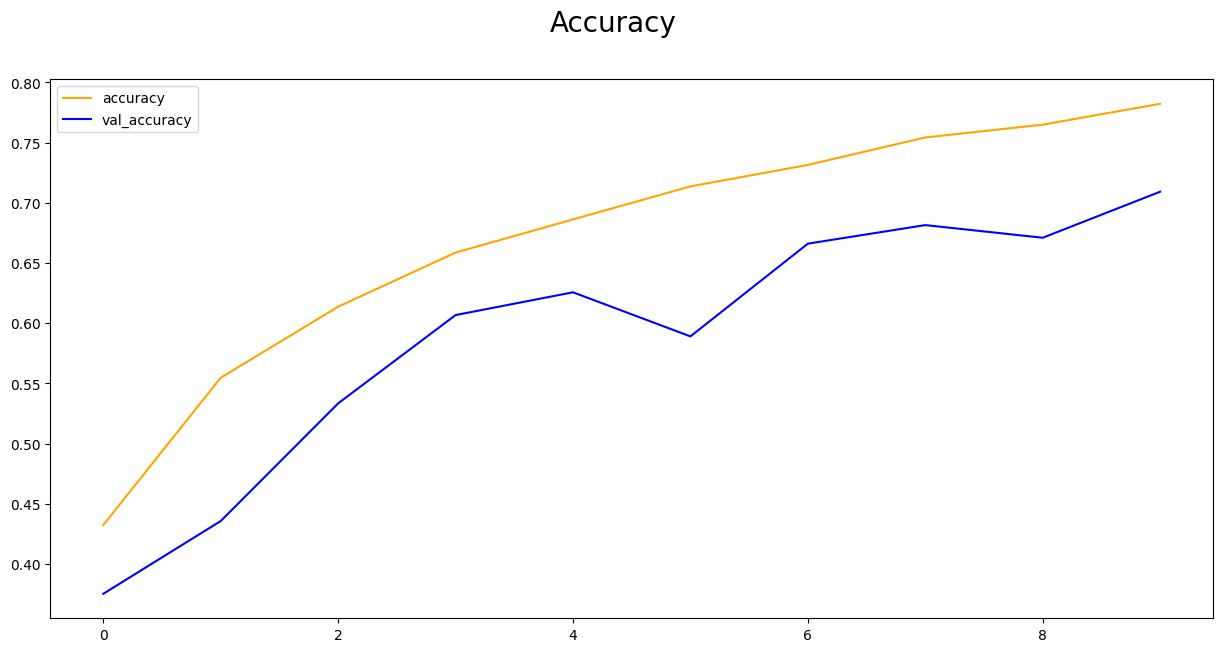

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'], color = 'orange', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
fig.suptitle ('Accuracy', fontsize = 20)
plt.legend()
plt.show()

In [ ]:
loss,accuracy=model.evaluate(X_test, Y_test)
print(f'The ResNet18 model accuracy is: {accuracy}')
print(f'The ResNet18 model loss is: {loss}')

313/313 [==============================] - 2s 5ms/step - loss: 0.8511 - accuracy: 0.7153
The ResNet18 model accuracy is: 0.7153000235557556
The ResNet18 model loss is: 0.851076066493988
